In [1]:
%pylab inline

import csv
from scipy.optimize import *
from numpy.lib.recfunctions import *
from utils import *
from graph_score import *
from graph_precall import *
import sys

Populating the interactive namespace from numpy and matplotlib


# Load data

Some notes:
    
* We need roughly the same amount of fishing and non-fishing rows to get good predictions,
but the source data for some vessel types contain mostly non-fishing rows, so we randomly
select 1000 fishing rows and the same number of non-fishing rows
* We add the log of the stddev columns, since their values are exponentially distributed

In [24]:
x = load('datasets/kristina_ps.measures.npz')['x']
x = concatenate((x[x['classification'] <= 0.5][:10000], x[x['classification'] > 0.5][:10000]))
numpy.random.shuffle(x)

all_windows = [int(name[len("measure_speedavg_"):]) for name in x.dtype.names if name.startswith("measure_speedavg_")]
all_windows.sort()
print all_windows

for window in all_windows:
    x = append_fields(x, 'measure_speedstddev_%s_log' % window, [], dtypes='<f8', fill_value=0.0)
    x['measure_speedstddev_%s_log' % window] = log10(x['measure_speedstddev_%s' % window]+0.001)

    x = append_fields(x, 'measure_coursestddev_%s_log' % window, [], dtypes='<f8', fill_value=0.0)
    x['measure_coursestddev_%s_log' % window] = log10(x['measure_coursestddev_%s' % window]+0.001)


x = append_fields(x, 'score', [], dtypes='<f8', fill_value=0.0)

length = x.shape[0]
xtrain = x[:length / 2]
xcross = x[length/2:length*3/4]
xtest = x[length*3/4:]

[1800, 3600, 10800, 21600, 43200, 86400]


# Optimum window size

Fit an optimum window size for the avg/std dev functions

1800: Fitting... Scoring... Calc.err... train=0.130419413864, cross=0.126592172526
3600: Fitting... Scoring... Calc.err... train=0.134503794534, cross=0.132023073354
10800: Fitting... Scoring... Calc.err... train=0.132033211211, cross=0.128947892193
21600: Fitting... Scoring... Calc.err... train=0.136958331619, cross=0.136304714641
43200: Fitting... Scoring... Calc.err... train=0.137442939717, cross=0.139418294932
86400: Fitting... Scoring... Calc.err... train=0.125211360402, cross=0.123360383432


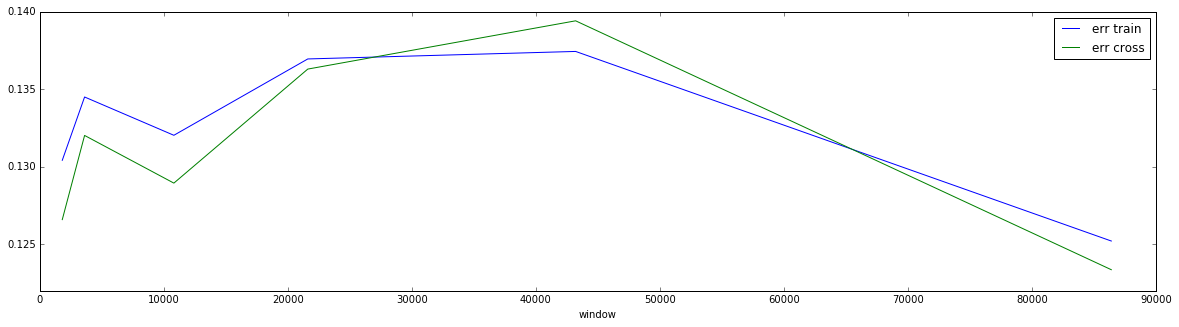

In [25]:
grade = 4
windows = array(all_windows)
err_train = zeros(windows.shape[0])
err_cross = zeros(windows.shape[0])

for idx, window in enumerate(windows):
    print "%s: Fitting..." % window,
    sys.stdout.flush()
    score_args = fit_score(xtrain, [window], grade)
    print "Scoring...",
    sys.stdout.flush()
    xtrain['score'][:] = zmpolynomial(get_polynomial_cols(xtrain, [window]), *score_args)
    xcross['score'][:] = zmpolynomial(get_polynomial_cols(xcross, [window]), *score_args)

    print "Calc.err...",
    sys.stdout.flush()
    xtrainclassified = xtrain[xtrain["classification"] != Inf]
    err_train[idx] = sum((xtrainclassified['score'] - xtrainclassified['classification'])**2)/xtrainclassified.shape[0]
    xcrossclassified = xcross[xcross["classification"] != Inf]
    err_cross[idx] = sum((xcrossclassified['score'] - xcrossclassified['classification'])**2)/xcrossclassified.shape[0]
    print "train=%s, cross=%s" % (err_train[idx], err_cross[idx])
    sys.stdout.flush()

min_window = windows[argmin(err_cross)]

figure(figsize=(20,5))
plot(windows, err_train, label="err train")
plot(windows, err_cross, label="err cross")
legend()
xlabel("window")
show()

# Optimum polynomial degree

Fit an optimum polynomial degree for the hypothesis function

2: Fitting... Scoring... Calc.err... train=0.156307326377, cross=0.154183140672
3: Fitting... Scoring... Calc.err... train=0.142325233197, cross=0.139601281811
4: Fitting... Scoring... Calc.err... train=0.125211360402, cross=0.123360383432
5: Fitting... Scoring... Calc.err... train=0.12426687811, cross=0.122263821974
6: Fitting... Scoring... Calc.err... train=0.123864879825, cross=0.122203739578
7: Fitting... Scoring... Calc.err... train=0.123708537466, cross=0.122167071477
8: Fitting... Scoring... Calc.err... train=0.123886280549, cross=0.122172016572
9: Fitting... Scoring... Calc.err... train=0.123922366023, cross=0.122463017195


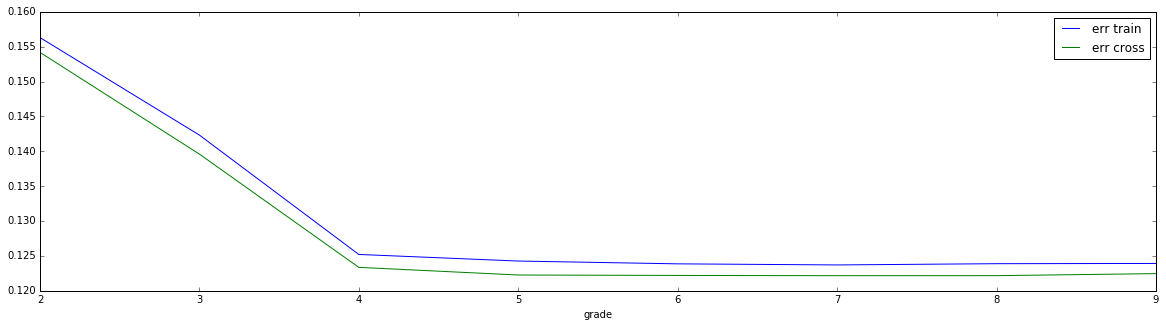

In [26]:
windows = [min_window]
grades = range(2, 10)
err_train = zeros(len(grades))
err_cross = zeros(len(grades))

for idx, grade in enumerate(grades):
    print "%s: Fitting..." % grade,
    sys.stdout.flush()
    score_args = fit_score(xtrain, windows, grade)
    print "Scoring...",
    sys.stdout.flush()
    xtrain['score'][:] = zmpolynomial(get_polynomial_cols(xtrain, windows), *score_args)
    xcross['score'][:] = zmpolynomial(get_polynomial_cols(xcross, windows), *score_args)
    
    print "Calc.err...",
    sys.stdout.flush()
    xtrainclassified = xtrain[xtrain["classification"] != Inf]
    err_train[idx] = sum((xtrainclassified['score'] - xtrainclassified['classification'])**2)/xtrainclassified.shape[0]
    xcrossclassified = xcross[xcross["classification"] != Inf]
    err_cross[idx] = sum((xcrossclassified['score'] - xcrossclassified['classification'])**2)/xcrossclassified.shape[0]
    print "train=%s, cross=%s" % (err_train[idx], err_cross[idx])
    sys.stdout.flush()
grades = array(grades)

figure(figsize=(20,5))
plot(grades, err_train, label="err train")
plot(grades, err_cross, label="err cross")
legend()
xlabel("grade")
show()

# Evaluation

Evaluate the chosen hypothesis against the test set

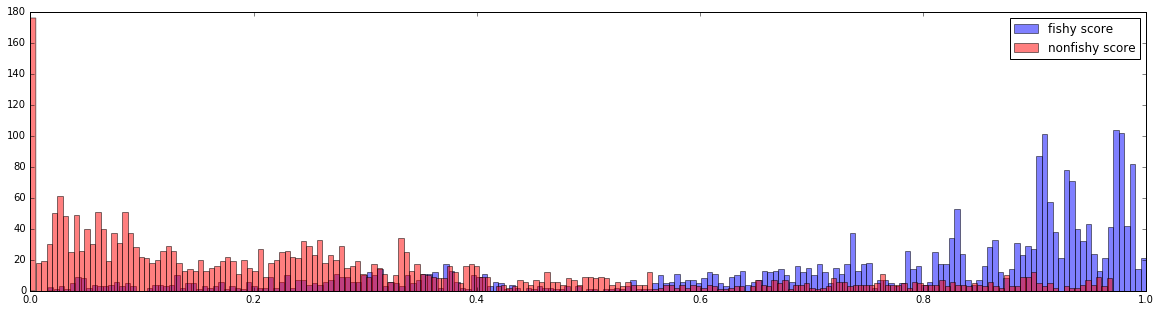

Squared numerical error: 0.134230401327
Error (overlap): 34.0%
False positives given cutoff at 0.5: 32.0523303352%


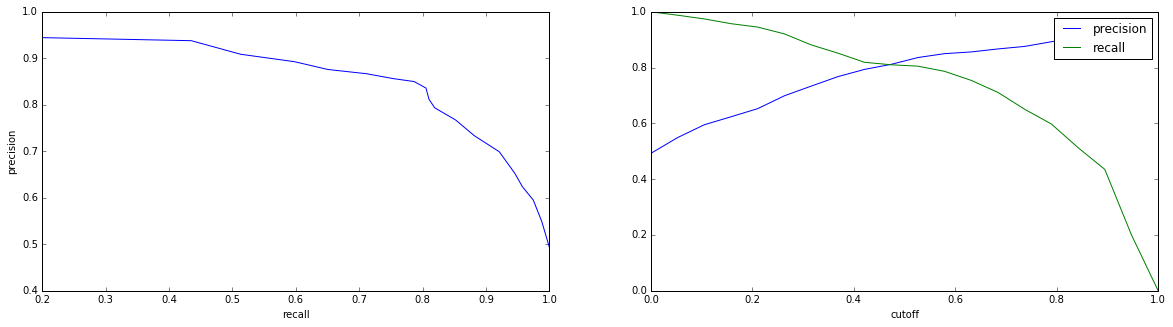

In [27]:
grade = 5
windows = [min_window]

score_args = fit_score(xtrain, windows, grade)
xtest['score'][:] = zmpolynomial(get_polynomial_cols(xtest, windows), *score_args)
graph_score(xtest, "score")
graph_precall(xtest, "score")

In [ ]:
print "Score window:", min_window
print "Score polynomial:", score_args

In [ ]:
import utils; reload(utils); from utils import *

In [9]:
sum(xtest['classification'] > 0.5)

224

In [12]:
x = load('datasets/kristina_ps.measures.npz')['x']
numpy.random.shuffle(x)

In [14]:
x.shape

(398897,)

In [23]:
concatenate((x[x['classification'] <= 0.5][:10], x[x['classification'] > 0.5][:10]))

array([ (0.0, 1371066583.0, 224523000.0, -150.9755667, 229.3, 4.567616667, 12.1, 0.28823529411764703, 0.6369444444444444, 0.010478203411575581, 0.28858131487889266, 0.0015222848722995198, 1e+20, 0.010435792386820757, 0.28905228758169926, 0.0015221117576166639, 1e+20, 0.01089209628401817, 0.2928467683369643, 0.0018244210384455862, 1e+20, 0.01089209628401817, 0.2928467683369643, 0.0018244210384455862, 1e+20, 0.34329309542840963, 0.6751093825960136, 0.21096031328783907, 1e+20, 0.3385569871383013, 0.5518484353934577, 0.25659763041633926, 1e+20),
       (0.0, 1340155653.0, 432410000.0, 141.637105, 351.3, 10.03949167, 14.8, 0.12941176470588234, 0.9758333333333333, 0.004446640858932111, 0.12941176470588237, 0.0013339473265056986, 1e+20, 0.005610550559931203, 0.13284313725490202, 0.0018919274760835754, 1e+20, 0.007397739349405191, 0.13848039215686278, 0.002869903635888629, 1e+20, 0.007397739349405191, 0.13848039215686278, 0.002869903635888629, 1e+20, 0.012369173694874797, 0.14140271493212675, 

In [21]:
x[x['classification'] > 0.5][:10]

array([ (1.0, 1357473512.0, 224089000.0, -18.765315, 55.6, 18.2445066667, 3.5, 0.7941176470588236, 0.15444444444444444, 0.034932262677624344, 0.7948235294117647, 0.05760052967220457, 1e+20, 0.034932262677624344, 0.7948235294117647, 0.05760052967220457, 1e+20, 0.033803062675836444, 0.7961729270021263, 0.05614568649442355, 1e+20, 0.03378161567666709, 0.7975232198142417, 0.05487188476094374, 1e+20, 0.04183175332844471, 0.8027332144979205, 0.12233374043489885, 1e+20, 0.06243804130374075, 0.7812400635930047, 0.1531358054466412, 1e+20),
       (1.0, 1371413196.0, 224523000.0, -153.16155, 319.3, 3.727116667, 0.5, 0.9705882352941176, 0.8869444444444444, 0.00967503883914304, 0.9663613948573441, 0.07327481929897135, 1e+20, 0.009630669673355545, 0.9663816689466482, 0.07254879371578625, 1e+20, 0.027530132414400423, 0.9619377162629758, 0.08940681946287966, 1e+20, 0.027530132414400423, 0.9619377162629758, 0.08940681946287966, 1e+20, 0.0216211870512615, 0.9703575547866206, 0.13754297545546937, 1e+20,